Examining Ultra-Trail du Mont-Blanc race results

Ultra-Trail du Mont-Blanc (UTMB) is a 166 km single-stage mountain ultra-marathon that follows the Tour du Mont Blanc hiking loop through 3 countries beginning and ending in Chaminox, France.  It is as well-known for its striking beauty and as it is for being an utterly brutal race with about 9,500 meters of elevation change and much of the race at over 2,500 meters above sea level.  When many summertime backpackers take 7 to 9 days to walk the entire trail, runners attempt to complete the route in just under 2 days.  Historically, the majority of runners do not finish due to missing the strict timing cutoffs.  While the best runners complete the loop in slightly more than 20 hours, most runners take 32 to 46 hours to reach the finish line and will have to run through two nights in order to complete the race. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind
from datetime import datetime, timedelta

Dataset: https://www.kaggle.com/ceruleansea/ultratrail-du-montblanc-20032017

The dataset was acquired from a post on Kaggle.  The user scaped the data from the UTMB Wikipedia page.  

The data was in a .csv format and each file contained the results by year.  Each dataset contained rows of data for each runner with attribute columns such as: name, rank, category, nationality, time and some timing splits denoting when each runner passed a landmark along the course.

The data needed some refining.  First, I excluded a couple years because of incomplete data - 2003 data did not have runners who did not finish(DNF).  In 2010, the race was halted due to poor weather.  2012 was included, but, that year the UTMB was only held as a 100K race due to heavy snow.

Nationality data was in both upper-case and lower-case formats so that needed to be cleaned up to be more consistant.  Nationality was also dropped from all DNF results.

In [18]:
# DATA YEARS ARE FROM 2003-17.  EXCLUDED 2003 (INCOMPLETE DATA) & 2010 (RACE WAS HALTED THEN RESTARTED)
# IN 2012, THE RACE WAS SHORTENED TO 100K DUE TO SNOW

years = ['04','05','06','07','08','09','11','12','13','14','15','16','17']
allresults = pd.DataFrame()

# TAKES DATA FROM .CSV FILES AND ADDS TO THE DATAFRAME
for x in years:
    # INTERATE THROUGH ALL THE DATA
    data = pd.read_csv('https://github.com/CascadiaRunner/Thinkful-Capstone-1/blob/master/utmb_20' + x + '.csv')
    
    # CHANGES ALL NATIONALITY DATA TO UPPERCASE
    data['nationality'] = data['nationality'].str.upper()
    
    # PULLS DATA FROM THE .CSV FILES FOR ANALYSIS
    allresults = pd.concat([data['rank'], 
                            data['nationality'], 
                            data['category'], 
                            data['name'], 
                            data['time']], axis=1).append(allresults)
    
allresults.head()

ParserError: Error tokenizing data. C error: Expected 1 fields in line 74, saw 4


Time data was imported as a string and needed to changed to timedelta format for analysis and visualization.  Below, I created a function that would convert the string to a timedelta.

In [3]:
def convert_string_to_datetime(time_string):
    # ADDED THE DAYS COLUMN TO THE TIME TO REPRESENT 1 24-HR PERIOD
    # MUST BE A NUMBERED DAY, HENCE '01' IS ADDED
    time_string = "01:" + str(time_string)
    
    # CONVERTING THE VALUES OVER 24 HOURS TO DAYS
    hrs = int(time_string[3:5])
    if hrs > 23:
        time_string = '02:' + str(hrs-24) + time_string[5:]
        
    # RETURNS TIMEDELTA WITH DAYS, HOURS, MINUTES, SECONDS    
    t=datetime.strptime(time_string, "%d:%H:%M:%S")
    delta = timedelta(days=t.day-1, hours=t.hour, minutes=t.minute, seconds=t.second)
    return delta

With the visualization below, we can see that the vast majority of runners finish the race in over 40 hours.  In fact, the median finishing time is 39 hours, 38 minutes. 

In [4]:
# REMOVE DNFS
justfinishers = allresults[allresults['nationality'] != ' ']
justfinishers = justfinishers.dropna()

# CHANGE CONVERT TIME STRING TO DATETIME
justfinishers['timeparse'] = justfinishers['time'].apply(convert_string_to_datetime)
justfinishers['timeparse'].median()

Timedelta('1 days 15:38:11.500000')

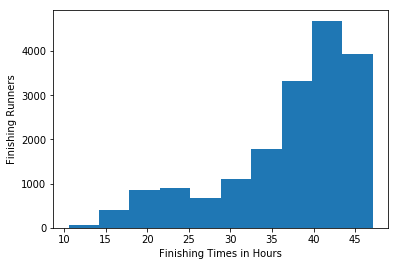

In [5]:
# CREATE A CHART SHOWING WHEN RUNNERS FINISH THE UTMB
justfinishers['hours'] = justfinishers['timeparse'].dt.total_seconds() / 60 / 60
plt.hist(justfinishers['hours'])
plt.xlabel('Finishing Times in Hours')
plt.ylabel('Finishing Runners')
plt.show()

Question 1: Which countries are the most representative at UTMB?  Do these nationalities attribute to the most success at UTMB?

The vast majority of UTMB finishers are from France which accounts for 50% of all UTMB finishers. France has almost five times as many finishers as the next country, Spain, which represents 11% of UTMB finishers.

In fact, 83% of UTMB finishers claim nationality from just 7 different countries. Three of the top 7 are countries which the UTMB passes through - France, Italy & Switzerland.  Also included in the top 7 are other mountainous western European countries - Spain, Germany & Great Britain.  Japan is the anomaly in the top 7.  It is a mountainous country but still a 14-hour flight from western Europe.

From these statistics, we can conclude that there is a strong regionality to this race and being from a top 7 country could possibly be an advantage. The question of nationality as an advantage could be hypothesis for further study down the road. 

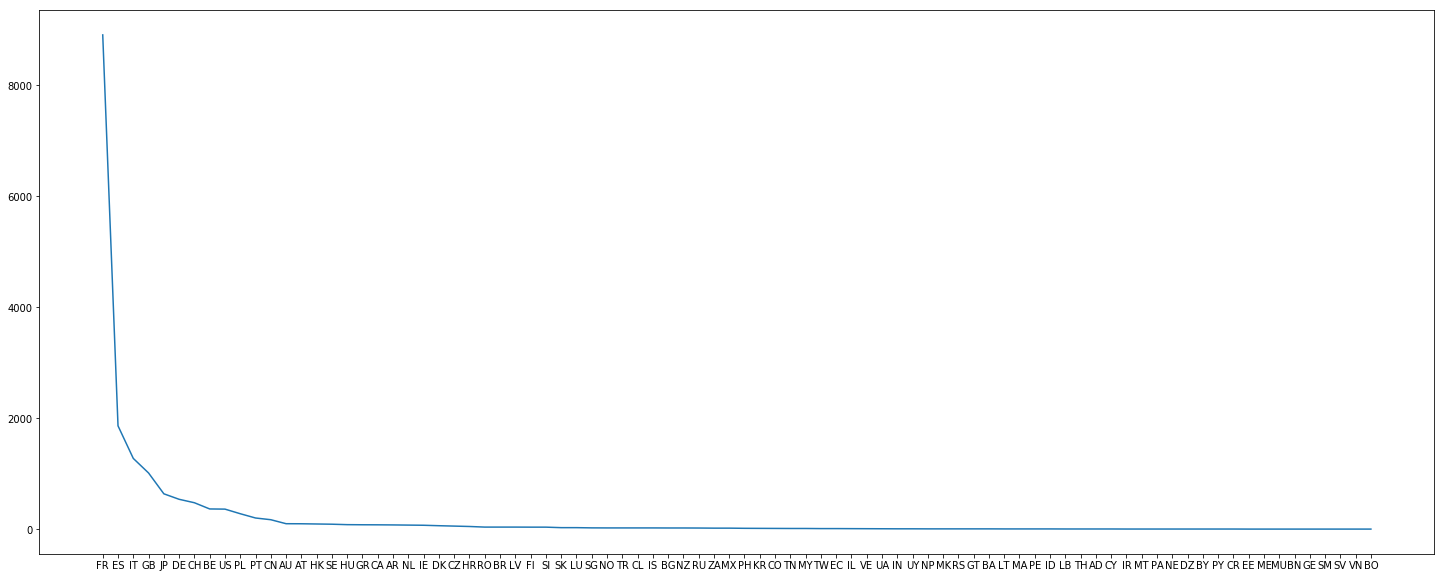

FR    8909
ES    1862
IT    1275
GB    1012
JP     637
dtype: int64

In [6]:
# PLOT NATIONALITY REPRESENTED AMONG UTMB FINISHERS
plt.figure(1, figsize=(25,10))
plt.plot(pd.value_counts(justfinishers['nationality'].values, sort=True))
plt.show()
pd.value_counts(justfinishers['nationality'].values).head()

In [7]:
nat_count = pd.value_counts(justfinishers['nationality'], sort=True)
# PERCENTAGES OF FINISHERS ARE FROM THE TOP COUNTRY?
print(nat_count.iloc[0].sum() / nat_count.sum())
# PERCENTAGES OF FINISHERS ARE FROM THE SECOND COUNTRY?
print(nat_count.iloc[1].sum() / nat_count.sum())
# PERCENTAGES OF FINISHERS ARE FROM THE TOP 7?
print(nat_count.iloc[:7].sum() / nat_count.sum())

0.5025383574007221
0.10503158844765342
0.8297044223826715


Question 2:
What age/gender group have the most success at UTMB?

UTMB puts age into three separate categories:
Espoirs (ES): 20-22 years old,
Seniors (SE): 23-39 years old, and
Masters (VH or VF depending on gender): 40+ years old

NOTE: Juniors: 19 years old and under are not allowed to run UTMB.

See the chart dataframe below for the category key.

In [8]:
pd.read_csv('https://github.com/CascadiaRunner/Thinkful-Capstone-1/blob/master/agecategories.csv')

,CATEGORY,CODE,AGE RANGE
0,Espoirs Men,ES H,20-22
1,Espoirs Women,ES F,20-22
2,Seniors Men,SE H,23-39
3,Seniors Women,SE F,23-39
4,Masters Men 1,VH 1,40-49
5,Masters Men 2,VH 2,50-59
6,Masters Men 3,VH 3,60-69
7,Masters Men 4,VH 4,70-79
8,Masters Men 5,VH 5,80+
9,Masters Women 1,VF 1,40-49


In [9]:
# MEN VS WOMEN PARTICIPANTS (H = MEN, F = WOMEN)
pd.value_counts(allresults['category'].str[-1].values)

H    27666
F     2541
dtype: int64

Men out number women participants 10 to 1 at UTMB.  Not surprisingly, the majority of UTMB finishers are also men.  Their top age categories are Seniors, Masters 1 and Masters 2.  In the data plot below we can see just how much more represented these age/gender groups are at UTMB over the others.  I used the describe function below to further break down the finisher categories. Observing the mean rank, standard deviation, min (best finish) we can observe that these 3 categories have performed better than the others. 

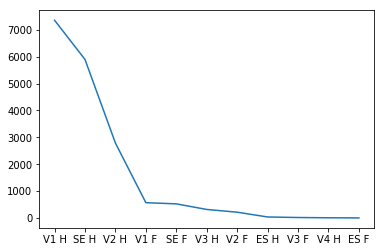

In [10]:
# UTMB FINISHERS BY CATEGORY
plt.plot(pd.value_counts(justfinishers['category'].values, sort=True))
plt.show()

In [11]:
justfinishers.groupby('category').describe()

hours                                                        \
           count       mean       std        min        25%        50%   
category                                                                 
ES F         1.0  38.636111       NaN  38.636111  38.636111  38.636111   
ES H        36.0  35.349522  7.989283  15.832222  31.066597  37.209444   
SE F       524.0  37.095372  7.830395  12.536944  32.590764  39.312639   
SE H      5900.0  36.091412  8.189974  10.543333  31.522917  38.578194   
V1 F       568.0  38.375591  8.160327  13.283611  35.596875  41.488750   
V1 H      7359.0  37.289099  7.692397  11.621667  34.138750  39.595556   
V2 F       214.0  38.767375  8.123456  15.240278  37.098819  42.018472   
V2 H      2788.0  38.220724  7.672561  14.158333  36.097431  40.906528   
V3 F        16.0  39.629063  6.662735  24.727500  37.204167  42.457500   
V3 H       316.0  38.322927  7.923356  15.151111  36.612778  41.326111   
V4 H         6.0  41.522731  4.548239  34.124722  39.440972  42.181667   

                                  rank                    ...                  \
                75%        max   count         mean       ...             75%   
category                                                  ...                   
ES F      38.636111  38.636111     1.0   511.000000       ...          511.00   
ES H      42.361528  45.609722    36.0   494.083333       ...          738.25   
SE F      43.387153  47.025000   524.0   735.591603       ...         1110.50   
SE H      42.569375  46.636944  5900.0   656.487627       ...         1006.00   
V1 F      44.432431  46.963056   568.0   933.897887       ...         1328.50   
V1 H      43.070278  46.920278  7359.0   745.118902       ...         1087.00   
V2 F      44.568194  46.711111   214.0  1045.528037       ...         1377.75   
V2 H      43.648056  47.143056  2788.0   862.873027       ...         1205.00   
V3 F      44.391528  45.549444    16.0  1021.937500       ...         1319.75   
V3 H      43.853681  46.597500   316.0   948.705696       ...         1295.50   
V4 H      44.829028  46.409444     6.0   786.666667       ...         1239.50   

                 timeparse                                                  \
             max     count                    mean                     std   
category                                                                     
ES F       511.0         1         1 days 14:38:10                     NaT   
ES H      1385.0        36  1 days 11:20:58.277777  0 days 07:59:21.417737   
SE F      2118.0       524  1 days 13:05:43.337786  0 days 07:49:49.420594   
SE H      2122.0      5900  1 days 12:05:29.083898  0 days 08:11:23.907116   
V1 F      2097.0       568  1 days 14:22:32.126760  0 days 08:09:37.175550   
V1 H      2121.0      7359  1 days 13:17:20.755945  0 days 07:41:32.630777   
V2 F      2106.0       214  1 days 14:46:02.551401  0 days 08:07:24.441047   
V2 H      2120.0      2788  1 days 14:13:14.605093  0 days 07:40:21.218918   
V3 F      2101.0        16  1 days 15:37:44.625000  0 days 06:39:45.846818   
V3 H      2107.0       316  1 days 14:19:22.537974  0 days 07:55:24.083095   
V4 H      1614.0         6  1 days 17:31:21.833333  0 days 04:32:53.659461   

                                                                           \
                      min                     25%                     50%   
category                                                                    
ES F      1 days 14:38:10         1 days 14:38:10         1 days 14:38:10   
ES H      0 days 15:49:56  1 days 07:03:59.750000         1 days 13:12:34   
SE F      0 days 12:32:13  1 days 08:35:26.750000  1 days 15:18:45.500000   
SE H      0 days 10:32:36  1 days 07:31:22.500000  1 days 14:34:41.500000   
V1 F      0 days 13:17:01  1 days 11:35:48.750000  1 days 17:29:19.500000   
V1 H      0 days 11:37:18  1 days 10:08:19.500000         1 days 15:35:44   
V2 F      0 days 15:14:25  1 days 13:05:55.750000  1 

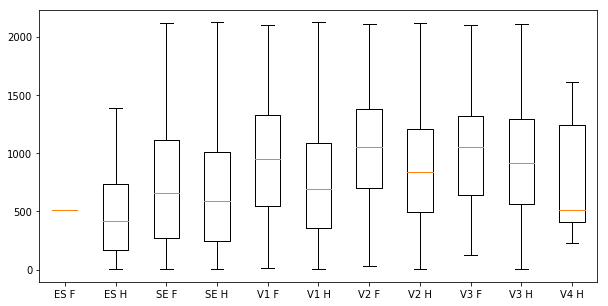

In [12]:
# CREATES A LIST OF CATEGORIES AND SORTS THEM
catlist = justfinishers['category'].unique()
catlist.sort()

rankedcat = []
# ITERATE THROUGH EACH CATEGORY TO GET EACH RUNNERS RANK
for x in catlist:
    rankedcat.append(justfinishers.loc[justfinishers['category'] == x, 'rank'])
    
# BOX PLOT OF CHECK CATEGORY
plt.figure(1, figsize=(10,5))
plt.boxplot(rankedcat, labels=catlist)
plt.show()

The box plots above shows the distribution of ranking of each category.  We can see a larger skew toward higher-ranking performances among the top 3 men's categories - ES H, SE H, and V1 H.

Given that these top 3 categories have similar rankings but different population counts, below is a 2 sample T-test to determine whether these categories are statistically different.  The ES H and SE H groups provided a p-value of 0.02 with 2.38 standard error units which would NOT indicate that these samples are different.  However, the SE H and V1 H group provided a p-value of 0.3e-37 which far below the 0.01 threshold and would indicate that these populations are different.   

In fact, age in the categories goes up from when looking at the box plots from left to right.  As age gets higher, the median ranking and skew become less pronounced.  From this, we can conclude that the average ranking does go up as the runners get older.

In [13]:
# T-TEST BETWEEN MEN 23-39 VS MEN 20-22
print(ttest_ind(justfinishers.loc[justfinishers['category'] == 'SE H', 'rank'],
                justfinishers.loc[justfinishers['category'] == 'ES H', 'rank'], 
                equal_var=False))

# T-TEST BETWEEN MEN 23-39 VS MEN 40-49
print(ttest_ind(justfinishers.loc[justfinishers['category'] == 'SE H', 'rank'],
                justfinishers.loc[justfinishers['category'] == 'V1 H', 'rank'], 
                equal_var=False))

Ttest_indResult(statistic=2.385721712962689, pvalue=0.022496170177007967)
Ttest_indResult(statistic=-10.816643816164978, pvalue=3.779521966872119e-27)


However, there an outliner - Marco Olmo.

In [14]:
# MARCO OLMO WON BACK TO BACK UTMB RACES IN 2006 AND 2007.
allresults[allresults['rank'] == 1]

,rank,nationality,category,name,time
0,1,FR,SE H,D'HAENE François,19:01:54
0,1,FR,V1 H,POMMERET Ludovic,22:00:02
0,1,FR,SE H,THEVENARD Xavier,21:09:15
0,1,FR,SE H,D'HAENE François,20:11:44
0,1,FR,SE H,THEVENARD Xavier,20:34:57
0,1,FR,SE H,D'HAENE François,10:32:36
0,1,ES,SE H,JORNET BURGADA Kilian,20:36:43
0,1,ES,ES H,JORNET BURGADA Kilian,21:33:18
0,1,ES,ES H,JORNET BURGADA Kilian,20:56:59
0,1,IT,V2 H,OLMO Marco,21:31:58


Marco Olmo is an Italian ultra-runner who won UTMB in 2006 and 2007.  He was 58 and 59 years old when he won!  Last year at age 69, he finished 49th of 1000 runners in the brutal 230km Marathon Des Sables which takes place in the Sahara Desert.

Question 3: Which categories have the best finishing times?  What can we see that is different than looking at rank?

For this question, I removed 2012 since that race was shortened to a 100 km and the times were drastically different than the 160 km times.

In [15]:
# TIME ANALYSIS WITHOUT 2012 RACE
years_without_12 = ['04','05','06','07','08','09','11','13','14','15','16','17']
results = pd.DataFrame()

for x in years_without_12:
    # INTERATE THROUGH ALL THE DATA
    data = pd.read_csv('https://github.com/CascadiaRunner/Thinkful-Capstone-1/blob/master/utmb_20' + x + '.csv')
    
    # CHANGES ALL NATIONALITY DATA TO UPPERCASE
    data['nationality'] = data['nationality'].str.upper()
    
    # PULLS DATA FROM THE .CSV FILES FOR ANALYSIS
    results = pd.concat([data['rank'], 
                         data['nationality'], 
                         data['category'], 
                         data['name'], 
                         data['time']], axis=1).append(results)

# REMOVE DNFS
results = results[results['nationality'] != ' ']
results = results[results['time'] != np.nan]

In [16]:
# CONVERT TIME FROM STRING TO TIMEDELTA FORMAT
results.sort_values(['time'], inplace=True)
results = results.dropna()
results['timeparse'] = results['time'].apply(convert_string_to_datetime)
results['hours'] = results['timeparse'].dt.total_seconds() / 60 / 60

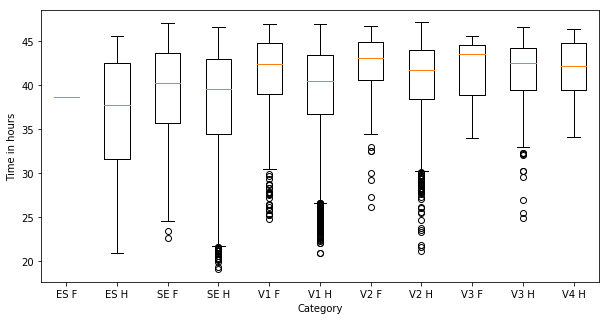

In [17]:
# CREATE BOX PLOTS OF FINISHING TIMES BY CATEGORY
rankedcat = []
for x in catlist:
    rankedcat.append(results.loc[results['category'] == x, 'hours'])
    
plt.figure(1, figsize=(10,5))
plt.boxplot(rankedcat, labels=catlist)
plt.ylabel('Time in hours')
plt.xlabel('Category')
plt.show()

This time data clearly shows the majority of all runners in all categories finish around 40 hours which supports the point in the introduction that the majority of runners finish later in the race.  However, these box plots also show us where the prevalence of outlier values are.  There are many more outliers among men than women and men have faster extreme values when comparing the same age group to women.  Additionally, there are many more outliers in the older age groups than younger. 

These outliners tell us about the variability for the dataset.  Perhaps we have not seen a true representation of how a true sampling across all runners will perform at UTMB.  Most likely, due to the reputation of this race being extreme and difficult, the only runners who end up running tend to be some of the top runners in the world.  (And the top outliners, like Macro Olmo!)  Hence, the distribution is skewed with the bottom whisker showing the top 25% of values being much larger than the top whisker representing the bottom 25%.

Future Projects: I think this dataset can be used as a predictive model for future runner performances and even a live assessment of the probability of finishing.  This can be done using machine learning and analyzing the live split-timing from the course and comparing them to historic-timing and results based on the runner category.  The basic analytical question is “Will this runner finish the race given their time and location on the course?”  This would be helpful for runners, coaches and race organizers to have a good idea of how many runners are about to DNF the race at any given time.  It can also help detect possible cheaters and course cutting.